## 7.2 小批量随机梯度下降

> 1. **批量梯度下降:使用整个训练数据集**
> 2. **随机梯度下降:随机使用某个样本**
> 3. **小批量随机梯度下降:每轮迭代中随机均匀采样多个样本来组成一个小批量**

1. **目标函数$f: \mathbb{R}^d \rightarrow \mathbb{R}$,开始迭代记为时间不0,$\boldsymbol{x}_0 \in \mathbb{R}^d$;通常由随机初始化得到**
2. **接下来每个时间步$t > 0$;随机均匀采样一个由训练数据样本索引组成的小批量$\mathcal{B}_t$,可以通过重复采样或者不重复采样**
$$\boldsymbol{g} \leftarrow \nabla f_{\mathcal{B}_{t}}(\boldsymbol{x}_{t-1}) = \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \nabla f_i(\boldsymbol{x}_{t-1})$$
**来计算时间步$t$的小批量$\mathbb{B}_t$上目标函数位于$\boldsymbol{x}_{t-1}$处的梯度$\boldsymbol{g}_t$; $|\mathcal{B}|$是超参数,小批量样本的个数;重复采样得到的小批量随机梯度$\boldsymbol{g}_t$也是对梯度$\nabla f(\boldsymbol{x}_{t-1})$的无偏估计**
3. **小批量随机梯度下降对自变量的迭代如下**
$$\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \eta_t \boldsymbol{g}_t$$
4. **小批量随机梯度的学习率可在迭代中自我衰减;例如$\eta_t = \eta t^{\alpha}$(通常$\alpha=-1或者-0.5$),$\eta_t = \eta \alpha^t$(例如$\alpha=0.95$);这样学习率和小批量随机梯度乘机的方差会减小;而梯度下降在迭代时一直使用目标函数的真实梯度,无需衰减学习率**

### 7.3.1 读取数据

In [5]:
%matplotlib inline
import numpy as np
import time
import torch
from torch import nn, optim
import sys
sys.path.append("..") 
import d2lzh_pytorch.utils as d2l

In [28]:
def get_data_ch7():
    data = np.genfromtxt("../../../data/airfoil_self_noise.dat", delimiter='\t')
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    return torch.tensor(data[: 1500, :-1], dtype=torch.float32), torch.tensor(data[:1500, -1], dtype=torch.float32)

features, labels = get_data_ch7()
# print(features[:20, :])
features.shape

torch.Size([1500, 5])

### 7.3.2 从零开始实现

In [29]:
def sgd(params, states, hyperparams):
    for p in params:
        p.data -= hyperparams['lr'] * p.grad.data

In [34]:
def train_ch7(optimizer_fn, states, hyperparams, features, labels,
             batch_size=10, num_epochs=2):
    net, loss = d2l.linreg, d2l.squared_loss
    
    w = torch.nn.Parameter(torch.tensor(np.random.normal(0, 0.01, size=(features.shape[1], 1)), dtype=torch.float32),
                          requires_grad=True)
    b = torch.nn.Parameter(torch.zeros(1, dtype=torch.float32), requires_grad=True)
    
    def eval_loss():
        return loss(net(features, w, b), labels).mean().item()
    
    ls = [eval_loss()]
    
    data_iter = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(features, labels), batch_size, shuffle=True)
    
    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            l = loss(net(X, w, b), y).mean()
            
            # 梯度清零
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            l.backward()
            
            optimizer_fn([w, b], states, hyperparams)
            if (batch_i+1) * batch_size % 100 == 0:
                ls.append(eval_loss())
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    d2l.set_figsize()
    d2l.plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    d2l.plt.xlabel('epoch')
    d2l.plt.ylabel('loss')


loss: 0.243298, 0.014019 sec per epoch


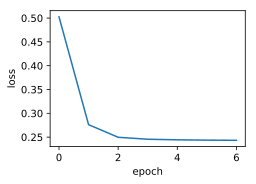

In [35]:
def train_sgd(lr, batch_size, num_epochs=2):
    train_ch7(sgd, None, {'lr': lr}, features, labels, batch_size, num_epochs)

# batch_size = 1500, 此时进行6次全量迭代,一个迭代周期会对子变量进行1500次更新
# 目标函数值的下降在1个迭代周期后就变得较为平缓
train_sgd(1, 1500, 6)

loss: 0.242692, 0.453786 sec per epoch


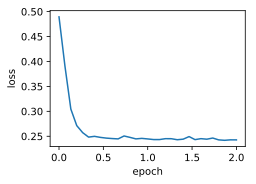

In [36]:
# batch_size = 1
train_sgd(0.005, 1)

loss: 0.245124, 0.072805 sec per epoch


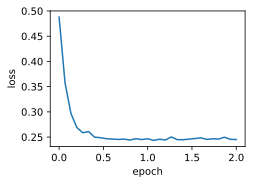

In [37]:
train_sgd(0.05, 10)

### 7.3.3 简洁实现

In [39]:
def train_pytorch_ch7(optimizer_fn, optimizer_hyperparams, features, labels,
                     batch_size=10, num_epochs=2):
    net = nn.Sequential(
        nn.Linear(features.shape[-1], 1)
    )
    loss = nn.MSELoss()
    
    optimizer = optimizer_fn(net.parameters(), **optimizer_hyperparams)
    
    def eval_loss():
        return loss(net(features).view(-1), labels).item() / 2
    
    ls = [eval_loss()]
    data_iter = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(features, labels), batch_size, shuffle=True)
    
    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            l = loss(net(X).view(-1), y) / 2
            
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    d2l.set_figsize()
    d2l.plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    d2l.plt.xlabel('epoch')
    d2l.plt.ylabel('loss')

loss: 0.247485, 0.052859 sec per epoch


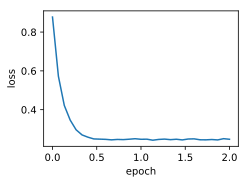

In [40]:
train_pytorch_ch7(optim.SGD, {"lr": 0.05}, features, labels, 10)